In [1]:
import skimage.io as io
import pandas as pd
import os
import warnings
warnings.filterwarnings("ignore")  # skimage warns when saving uint16 with not covering full range of 0-65535
example_root = os.path.join(os.path.dirname(os.path.dirname(os.path.abspath('__file__'))), 'examples')

## Evaluation with Cell Tracking Challenge (CTC) Matrices

### Author: Yifan Gui @ Kuan Yoow Chan group
#### _WARNING_: Running the entire tutorial will create data size ~1.24 GB under 'pcnaDeep/example'

The __Cell Tracking Challenge (CTC)__ matrices objectively evaluate segmentation and tracking performance of an algorithm. Alghtough not designed for scoring cell cycle profiling, we can forget cell cycle phases for the time being, and feed our results to CTC evaluation software.

File format readable by CTC evaluation software should be in the structure of:

|---001  
|---001_GT  
|---001_RES  

 where some dataset is labeled with 001. Raw image stored in 001 folder, ground truth in 001_GT, and result in 001_RES.  
See CTC official descriptions for image format and detailed naming conventions.

pcnaDeep package offers the class __pcna_ctcEvaluator__ and a few APIs for transfering __raw image__, __standard output__ (multipage .tif mask and track .csv table), and deepcell_caliban-curated __ground truth__ to CTC-readable format. 

### Initialize pcnaDeep.pcna_ctcEvaluator

In [2]:
from pcnaDeep.evaluate import pcna_ctcEvaluator

The class is initialized with these parameters:
- root  
    &emsp;Directory to the folder where you wish to store all informations in CTC format.
- dt_id  
    &emsp;ID of dataset
- digit_num:  
    &emsp;Digit count of id (e.g. 001 should corresponding to digit_num=3)
- t_base  
    &emsp;Time for naming the first frame, defult is 0.
    
We will create a new folder under '/examples/CTC' to store this toy dataset named with 0001. The is done when the class is initialized, but you can block this behavior through parameter _init_dir_=False

___WARNING___ If you have already initiated the directory before, set `init_dir=False`.

In [3]:
ev = pcna_ctcEvaluator(root=os.path.join(example_root, 'CTC'), dt_id=1, digit_num=4, t_base=0, init_dir=True)

### &emsp;Dataset
The example dataset is a 66-frame MCF-10A cell image stack filmed with a confocal microscopy and 60X objective, which has 2 mitosis events and xxx cell tracks.

In [4]:
stack = io.imread(os.path.join(example_root, 'MCF10A', '10A_cpd.tif'))
stack.shape

(66, 1200, 1200, 3)

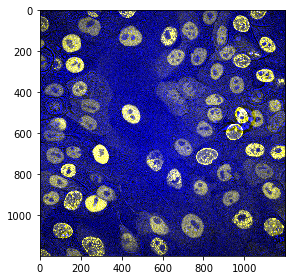

In [5]:
import matplotlib.pyplot as plt
io.imshow(stack[0,:])
plt.show()

---

### 1. Convert raw .tif stack to CTC format (not necessary for calculating CTC scores)
The method __`generate_raw( )`__ takes in a multipage stack (THWC format) and save it to corresponding folder.

By convention, let's extract the first channel of the input stack and save images as gray scale (PCNA signal only).

In [6]:
ev.generate_raw(stack[:,:,:,0])

---

### 2. Convert ground truth to CTC GT format

Here we use the ground truth mask and the ground truth object table. 

_Note:_ To generate a ground truth mask, you may find function `pcnaDeep.data.utils.mask2json` useful. In practical, I use an integrative function `pcnaDeep.tracker.track_GT_json` to produce object table and mask at the same time. The object table is corrected through the correction interface.

In [7]:
mask = io.imread(os.path.join(example_root, 'MCF10A', '10A_cpd_GT_mask.tif'))
gt_table = pd.read_csv(os.path.join(example_root, 'MCF10A', '10A_cpd_tracks_GT_full.csv'))

If you have ever removed objects from the object table, you may find function `pcnaDeep.data.utils.align_table_and_mask` useful.  
The function will remove unmatched objects from the mask.

In [8]:
from pcnaDeep.data.utils import align_table_and_mask
mask = align_table_and_mask(gt_table, mask)

Removed 0 objects.


The `generate_ctc` function can generate either GT or RES. It will takes a while to process. The logic is explained in the below section.

In [9]:
ev.generate_ctc(mask, gt_table, 'GT')

---

### 3. Convert pcnaDeep output to CTC RES format

The method __`generate_ctcRES( )`__ process the tracked table, relabel the mask with track ID and save the mask together with res_track.txt (required by CTC evaluation) to the corresponding folder.  

To be specific, since CTC does not handle gapped track (e.g. a track that appears at frame 1-3, 5-10 but disappears at frame 4. Gapped tracks are particularly common in PCNA tracking data due to unstable fluorescent signal.), the method will first call __`pcnaDeep.data.annotate.relabel_trackID( )`__ to label track ID sequentially, then breaks all gapped tracks through __`pcnaDeep.data.annotate.break_track( )`__. The resulting tracks are assigned with new IDs and used to relabel the mask through __`pcnaDeep.data.annotate.label_by_track( )`__. Finally, a table will be drawn from __`pcnaDeep.data.annotate.get_lineage_txt( )`__ to output as res_track.txt. The table records track and lineage information in CTC conventional format.

In [12]:
mask = io.imread(os.path.join(example_root, 'MCF10A', 'testing', '10A_cpd_mask.tif'))
track = pd.read_csv(os.path.join(example_root, 'MCF10A', 'testing', '10A_cpd_tracks_refined.csv'))

In [13]:
ev.generate_ctc(mask, track, 'RES')

---

### 4. Evaluate with CTC evaluation software

### &emsp; 4.1 Automatic evaluation ( (Unix) Linux and Mac only)

`pcna_ctcEvaluator` offers handy interface for calling [CTC evaluation software](http://celltrackingchallenge.net/evaluation-methodology). 

To set the root directory (containing SEG/TRAMeasure binaries) to the program, use __`set_evSoft( )`__ (or through `path_ctc_software` parameter when initializing the object). 

To run evaluation, call __`evaluate( )`__ . SEG and TRA scores & logs will appear in \_RES foler

In [ ]:
ev.set_evSoft('<Your path to software here>')  # !!! Change the path before runing

In [ ]:
ev.evaluate()

### &emsp; 4.2 Commandline evaluation (Windows, Linux or Mac)

For running evaluation through commandline, please follow the [guidance of CTC evaluation software](http://celltrackingchallenge.net/evaluation-methodology).

All required files have been correctly organized in the steps before.

---

In [2]:
from pyversions import versions
import skimage
versions();

Darwin 21.2.0 64-bit Darwin Kernel Version 21.2.0: Sun Nov 28 20:28:54 PST 2021; root:xnu-8019.61.5~1/RELEASE_X86_64
CPython 3.7.9 (default, Aug 31 2020, 07:22:35) [Clang 10.0.0 ]
Jun 09 2022, 16:51:53

Module           Version
ipython           7.27.0
jupyterlab        3.0.10
notebook           6.4.0
numpy             1.18.5
pandas             1.2.4
pyversions         0.0.3
skimage           0.17.2
